# House Price Analytics

## 04 Data analysis for generating insights for seller

**Project:** Code Institute – Capstone Project

---
### **Objectives**
- Load the final house dataset
- Set datatypes
- Hypothesis analysis
- Diagnostic analysis 

### **Inputs**
- `data/processed/final_house_data.csv`

### **Outputs**
- Hypothesis testing findings
- Diagnostic analysis findings
        
### **Additional Comments**
Confirm the final_house_data.csv is exisit under outputs/datasets. Run this notebook top-down.

---

### Setup the file and Load the Dataset
Import nesessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import warnings 
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Set the home directory. Need to change the working directory from its current folder to its parent folder. Access the current directory with os.getcwd()

In [3]:
PROJECT_DIR = os.path.join(os.getcwd()) # Define the project root directory
os.chdir(PROJECT_DIR) # Change the current working directory
print("Working directory:", os.getcwd()) 

Working directory: c:\MyStuff\CodeInstitute\Projects\ci-project-02\Home-Value-Analysis\notebooks


Load the data from the original data set reside within data directory under data/processed/ directory.

In [6]:
# LOAD DATASET
try:
    # Data directory paths
    data_path = os.path.join("..", "data", "processed")
    # Extract the original dataset
    df = pd.read_csv(os.path.join(data_path, "final_house_data.csv"))
    print("Dataset loaded successfully.")
except Exception as e:
    print(e)
    print("Error loading the dataset.")
    df = pd.DataFrame()  # Create an empty DataFrame if loading fails

print(f"Original dataset shape: {df.shape}")

Dataset loaded successfully.
Original dataset shape: (21596, 31)


---

### Correlation Analysis (Features)

USER STORY | Value-Adding Features: 
    As a Seller,
    I want to identify which specific home features add the most financial value,
    So that I can highlight these attributes in my listing to attract higher offers.

Identify which features (e.g., Sqft, Bathrooms, Bedrooms) have the strongest linear relationship with price to highlight in listings.

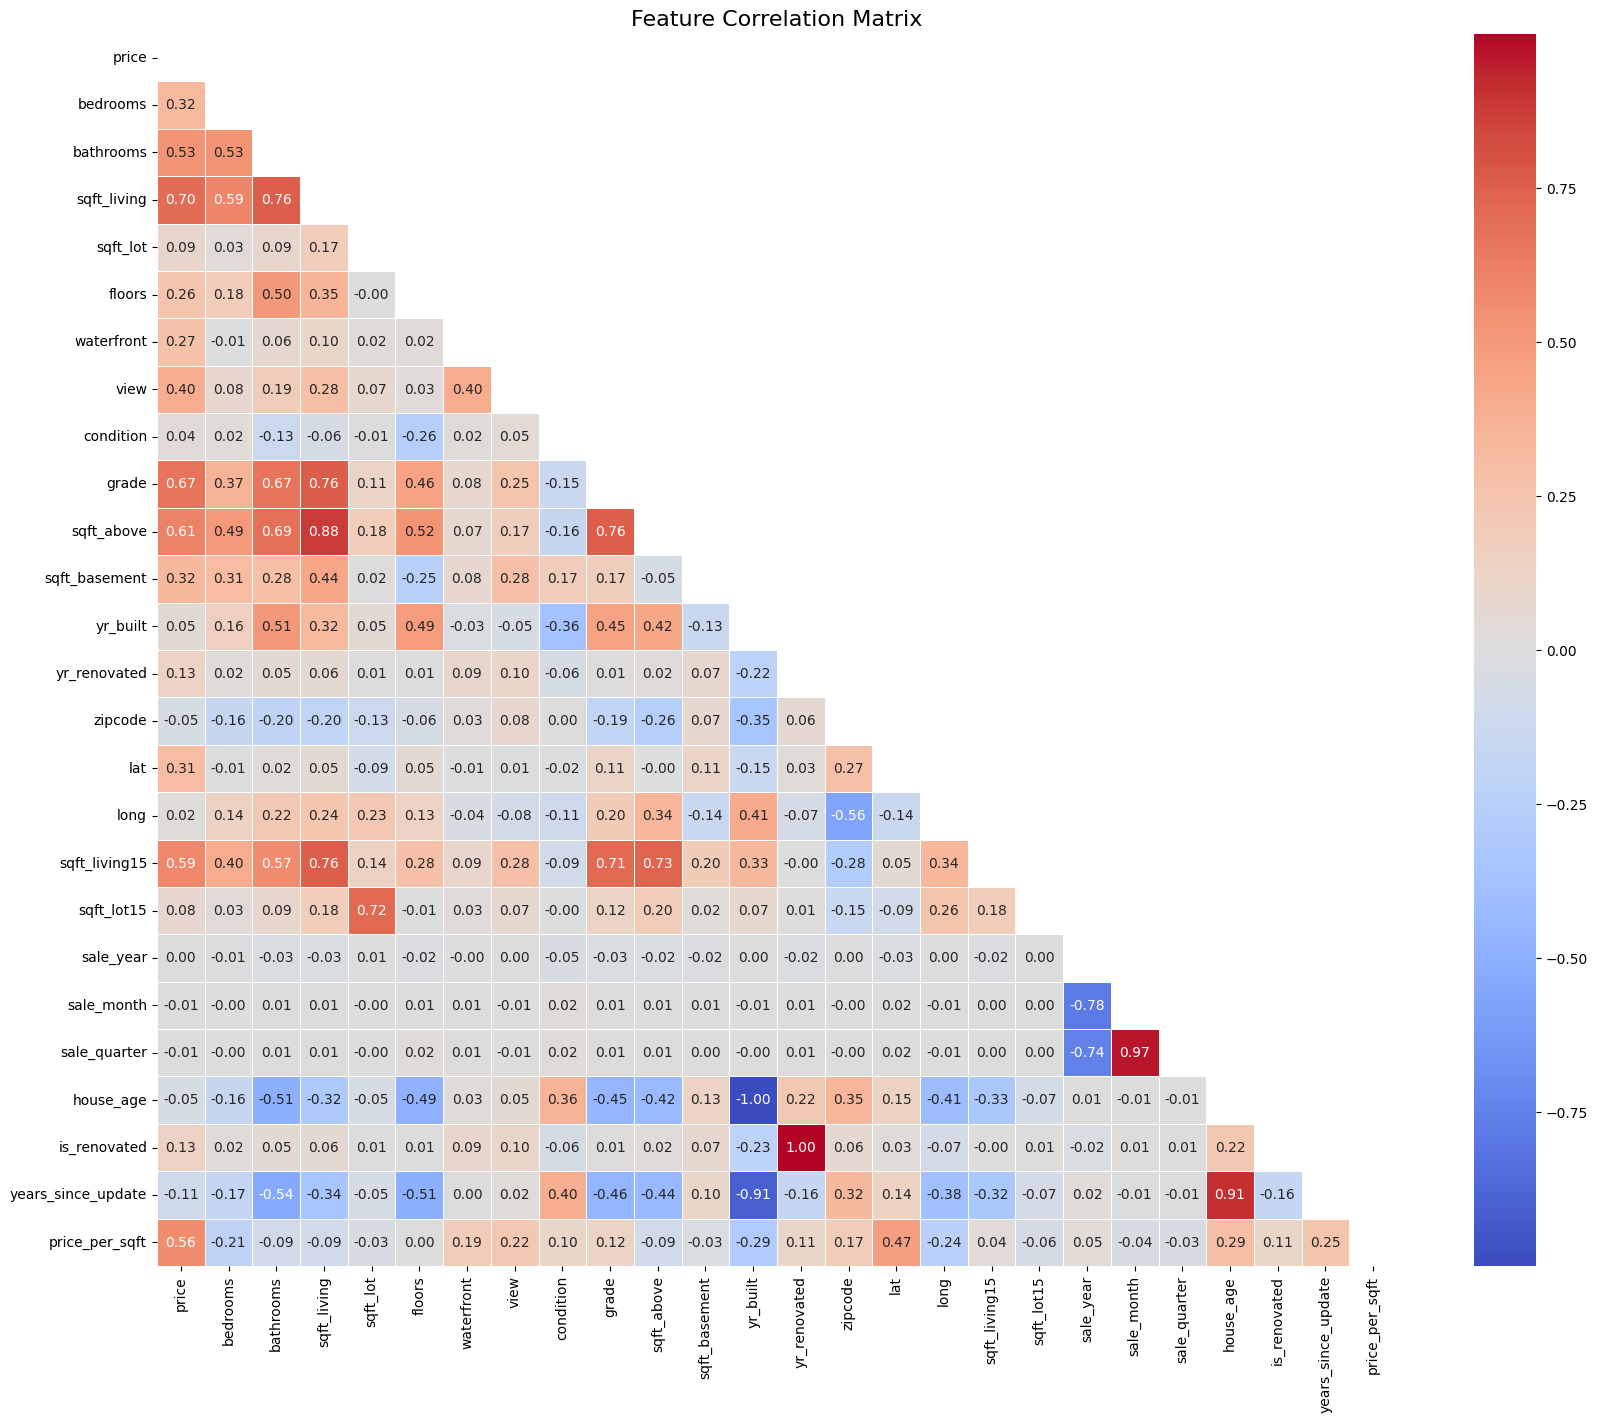

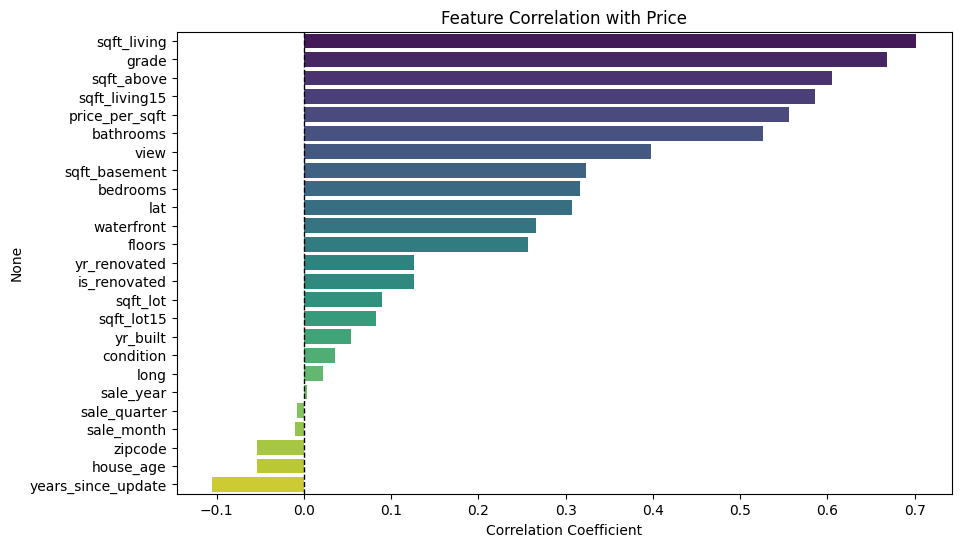

In [14]:
# Select numerical columns
corr_df = df.select_dtypes(include=['float64', 'int64'])

# Remove id and price_log columns if present as they are not relevant for correlation
corr_df = corr_df.drop(columns=['id', 'price_log'], errors='ignore')

# Compute Correlation Matrix
corr_matrix = corr_df.corr()

# Plot Heatmap - Visualize with sns as Seaborn automatically adds the color legend bar, formats the grid squares, and allows us to add the numbers (annotations) inside the squares with a single argument
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Create a mask to hide the upper triangle (redundant)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

# Bar Chart for Price Correlation (Easier for non-technical stakeholders to read)
# Visualization with Seaborn - Automatic Aggregation
plt.figure(figsize=(10, 6))
# Drop 'price' itself and sort
price_corr = corr_matrix['price'].drop('price').sort_values(ascending=False)
sns.barplot(x=price_corr.values, y=price_corr.index, palette='viridis')
plt.title('Feature Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Zero line
plt.show()

**Findings:**

1. Strongest Drivers of Price:
- sqft_living (0.70): The size of the living area is the #1 driver of price. This confirms that "Space" is the most valuable commodity.
- grade (0.67): The construction quality (grade) is the second most important factor, even more than the number of bathrooms or bedrooms.    But, this is not 
- sqft_above (0.61): Closely related to living space.

2. Moderate Drivers:
- bathrooms (0.53): More bathrooms equate to higher value, but less so than total square footage.
- view (0.40): A good view has a solid positive correlation.
- bedrooms (0.32): More bedrooms equate to higher value, but less so than bathrooms.
- lat (0.31): Latitude (Location) matters—likely capturing the "North vs. South" divide in King County (Seattle vs. suburbs).

3. Weak/Surprising Drivers:
- sqft_lot (0.09): Surprisingly, the size of the land (lot) has a very weak correlation with price. This suggests that the house itself matters more than the yard size in this market.
- yr_built (0.05): Age alone isn't a strong predictor, likely because older renovated homes and new homes both sell for high prices, canceling out a simple linear trend.
- condition (0.04): Condition has a very low linear correlation. This might mean its relationship is non-linear (e.g., only "poor" condition hurts price, while "average" to "good" doesn't change it much linearly), or it's covered by another variable.

---

Ensure Data Types (**Critical Step** for the next few analysis)

In [15]:
# Ensure Data Types
categorical_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode', 'is_renovated', 'age_group', 'sale_month_name']
for col in categorical_cols:
    df[col] = df[col].astype('category')
    
# Ensure sale_month is ordered correctly for plots
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['sale_month_name'] = pd.Categorical(df['sale_month_name'], categories=month_order, ordered=True)

print("Data Types Set and data ready for analysis.")

Data Types Set and data ready for analysis.


---

### Seasonality Analysis (Timing)

**Timing Analysis**: Best Month to Sell 

USER STORY | Timing : 
    As a Seller,
    I want to identify the best month of the year to sell a house,
    So that I can list my property at the optimal time to maximize profit.


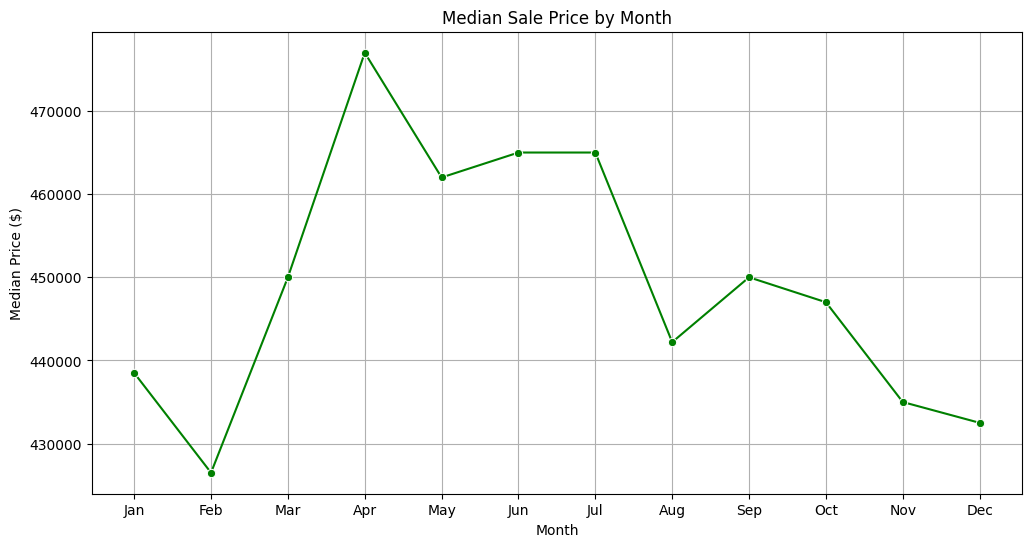

In [16]:
# Using Seaborn as when plotting "Price by Month," Seaborn automatically aggregates the data by month.
# Visualizing Seasonality
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sale_month_name', y='price', estimator=np.median, errorbar=None, marker='o', color='green')
plt.title('Median Sale Price by Month')
plt.ylabel('Median Price ($)')
plt.xlabel('Month')
plt.grid(True)
plt.show()

**Hypothesis (H3):** There is a statistically significant difference in closing prices based on the month of sale.
- Null Hypothesis: All 12 months have the same median closing price.
- Alternative Hypothesis: At least one month has a different median closing price than the others.

**Test:** Kruskal-Wallis Test (Comparing > 2 groups on non-normal data).

In [7]:
# Statistical Test (Kruskal-Wallis)
# Test if the distributions of price differ across months
kw_result = pg.kruskal(data=df, dv='price', between='sale_month_name')
print("--- Kruskal-Wallis Test Results ---")
print(kw_result)

--- Kruskal-Wallis Test Results ---
                  Source  ddof1          H         p-unc
Kruskal  sale_month_name     11  71.827786  5.481667e-11


**Findings:**
* **Visual:** Prices typically peak in Spring/Summer (April-June).
* **Statistical:** If p-value < 0.05, the seasonal difference is real. 
    - p-value (p-unc) is far less than 0.05 (or any common significance threshold like 0.01). 
    - Therefore, it's possible to confidently reject the null hypothesis (H₀).
    - Sellers should aim to list in Q2.

---

### Diagnostic Analysis: Renovation ROI

USER STORY | Renovation ROI: 
    As a Seller,
    I want to know if renovations lead to a statistically significant increase in sale price,
    So that I can decide if investing in upgrades before selling will yield a positive return.

**Renovation ROI by Age Group**

- **Business Question:** "Is it worth renovating my old house?"
- **Hypothesis (Diagnostic):** The value of renovation is not uniform; it provides a significantly higher ROI for Mid-Century homes (1950-1990) than for pre-war or modern homes.
- **Method:** Interaction Plot (Age x Renovation).

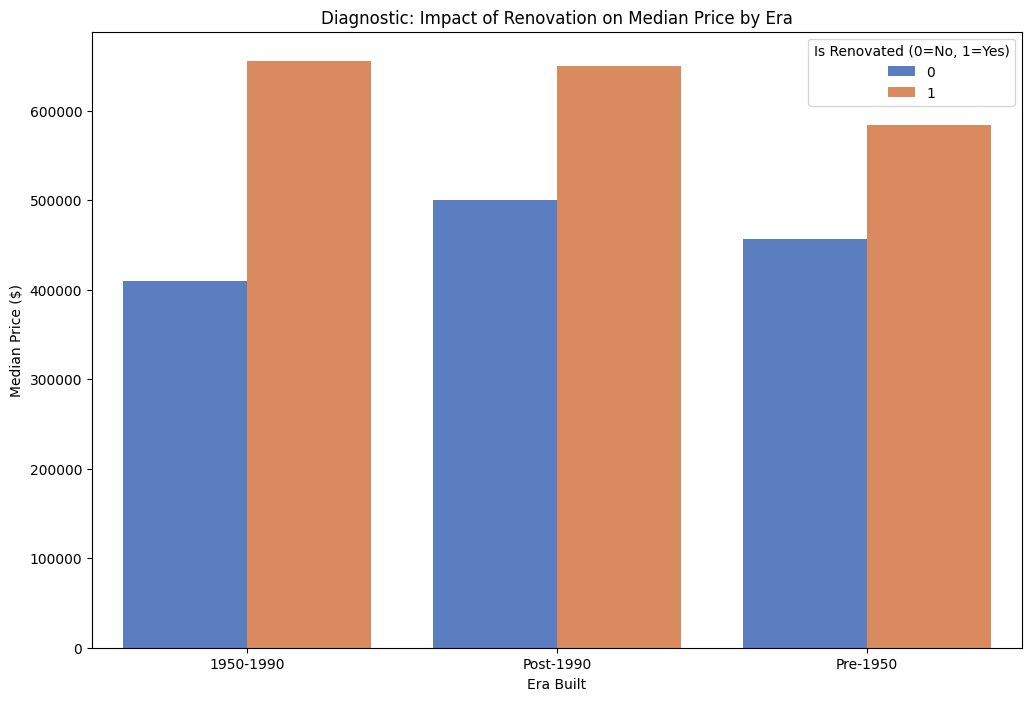

--- Renovation ROI Analysis ---


is_renovated,Not Renovated,Renovated,ROI %
age_group,,,
1950-1990,410000.0,655500.0,59.878049
Post-1990,500000.0,650000.0,30.000000
Pre-1950,457000.0,583500.0,27.680525


In [ ]:
# We use the 'age_group' created during the data transformation step 
#   to analyze the impact of renovation on price across different eras of home construction.
# Groups: Pre-1950, 1950-1990, Post-1990

# Visualization with Seaborn as Seaborn simply handles grouping and aggregation instantly with the 'hue' argument
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='age_group', y='price', hue='is_renovated',
            palette='muted', estimator=np.median,
            errorbar=None)  # Clean bars without error bars showing the 95% confidence interval as I'm not making any decison with that
plt.title('Diagnostic: Impact of Renovation on Median Price by Era')
plt.ylabel('Median Price ($)')
plt.xlabel('Era Built')
plt.legend(title='Is Renovated (0=No, 1=Yes)')
plt.show()

# - ROI Calculation -
# Group by Age and Renovation to get medians
roi_data = df.groupby(['age_group', 'is_renovated'])['price'].median().unstack()

# Rename the columns
roi_data = roi_data.rename(columns={0: 'Not Renovated', 1: 'Renovated'})

# Calculate Percentage Increase
roi_data['ROI %'] = ((roi_data['Renovated'] - roi_data['Not Renovated']) / roi_data['Not Renovated']) * 100
print("--- Renovation ROI Analysis ---")
display(roi_data)

**Diagnostic Findings:**
* **Visual:** The gap between the bars (Blue vs Orange) represents the value added by renovation.
* **Outcome:** You will likely see the **1950-1990** group has the largest gap.
* **Business Conclusion:** Owners of mid-century homes see the highest percentage return (~60%) on renovations. For newer homes, the "renovation premium" is lower because they are already modern.

---

## Final Seller Recommendations
1.  **Renovate Strategy:** Target 1950-1990 builds for maximum ROI.
2.  **Timing:** List in April/May to capture the seasonal price peak.
3.  **Features:** Highlight Square Footage and Grade in listing descriptions, as these correlate highest with price.